# Multiple Detections & False Positives Exerciese

Below are presented six consecutive frames from the project video and I'm showing all the bounding boxes for where my classifier reported positive detections. I can see that overlapping detections exist for each of the two vehicles and in two of the frames, I find a false positive detection on the guardrail to the left. In this exercise, I'll build a heat-map from these detections in order to combine overlapping detections and remove false positives.

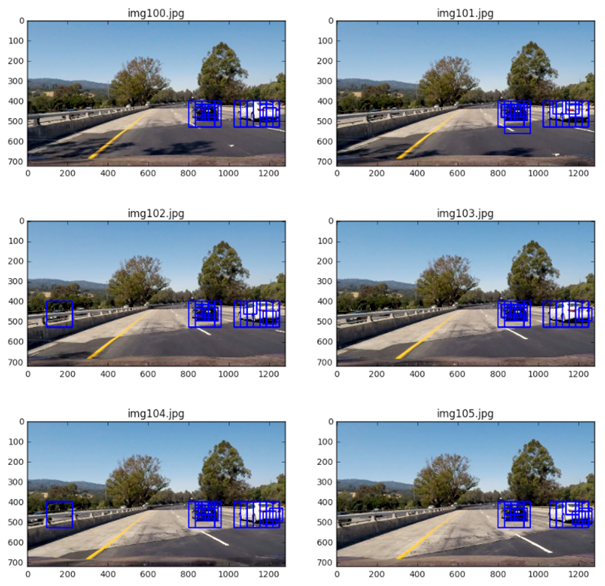

To make a heat-map, I am simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by my classifier. The individual heat-maps for the above images look like this:

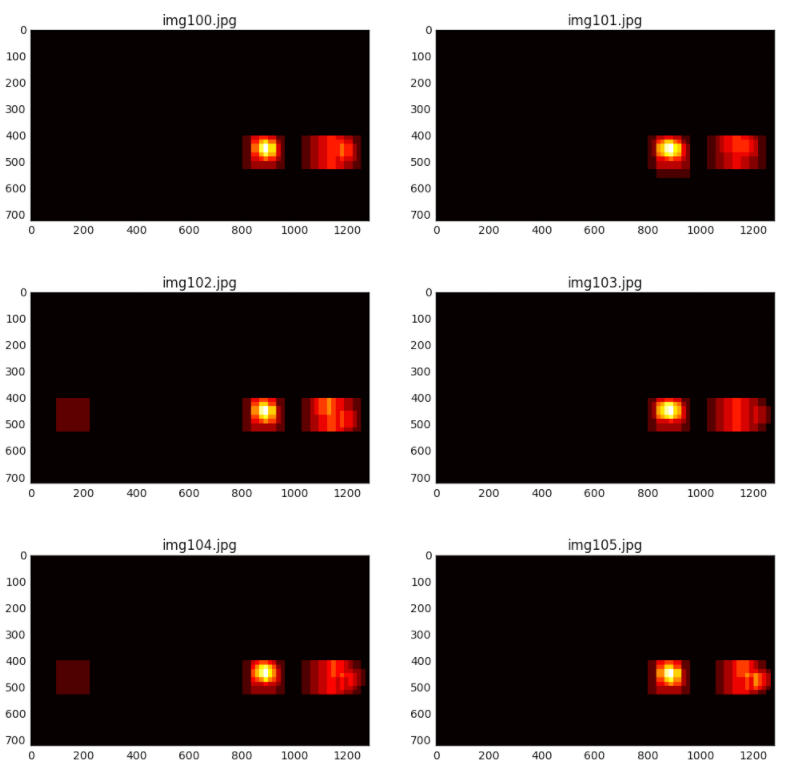

In the add_heat function below,a list of bounding boxes for the detections in the images shown above will be passed. Rather than consider heat-maps for each individual image, the function adds "heat" to a map for a list of bounding boxes.

~~~python
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
~~~

If my classifier is working well, then the "hot" parts of the map are where the cars are, and by imposing a threshold, I can reject areas affected by false positives. Below is  written a function to threshold the map as well.

~~~python
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
~~~

In practice, I will want to integrate a heat map over several frames of video, such that areas of multiple detections get "hot", while transient false positives stay "cool". I can then simply threshold my heatmap to remove false positives.

Once I have a thresholded heat-map, there are many ways to figure out how many cars I have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the label() function from scipy.ndimage.measurements. I'll use it like this:

~~~python
from scipy.ndimage.measurements import label
labels = label(heatmap)
~~~

Now labels is a 2-tuple, where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.

In the above series of images the same false positive window appeared twice, so if I set a threshold of 2 (meaning set all values <= 2 to 0) and then run the labels() function. I get a result that 2 cars were identified (the two islands in the heat-map) and the labeled image where pixels are set to 0 for background, 1 for car number 1, and 2 for car number 2.

~~~python
heatmap = threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
~~~

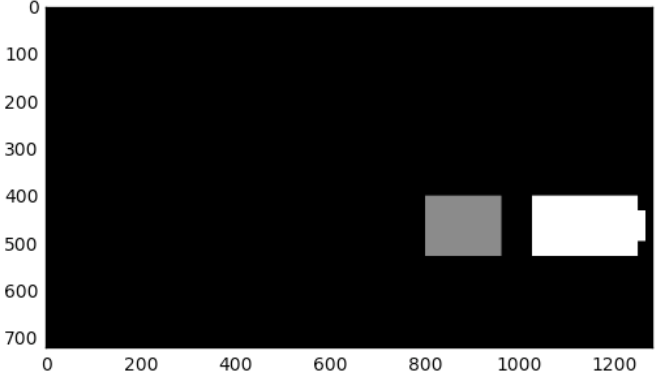

Next, I can take my labels image and put bounding boxes around the labeled regions. I could do this in the following manner:

~~~python
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in the last image above
image = mpimg.imread('img105.jpg')
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

~~~

 And the output looks like this:

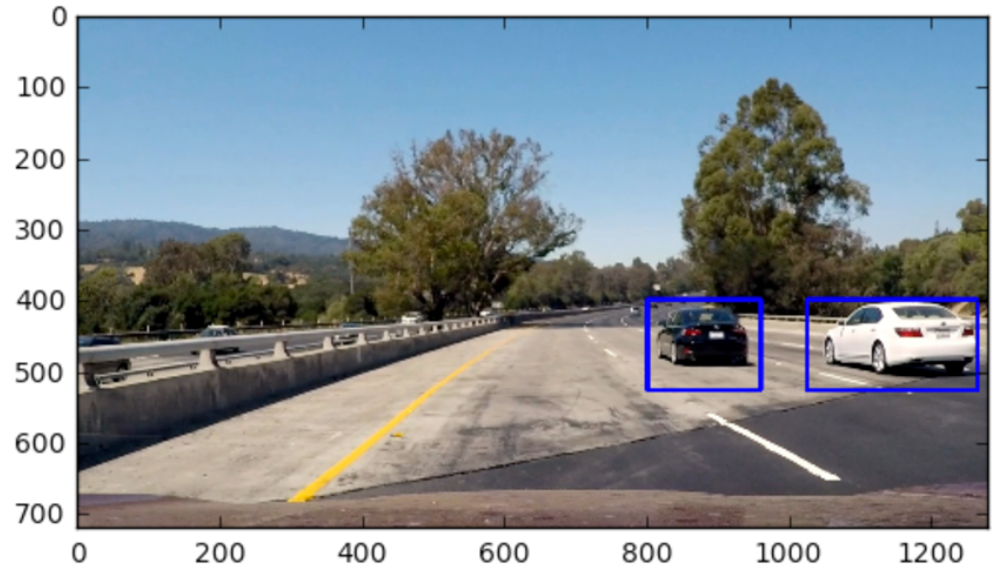

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn import svm
from scipy.ndimage.measurements import label
from allFunction import *

C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pickle_file=open('../code/svc.p','rb')#svc_pickle.p


dist_pickle = pickle.load(pickle_file)

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel=dist_pickle["hog_channel"]
color_space=dist_pickle["color_space"]
spatial_feat=dist_pickle['spatial_feat']
hog_feat=dist_pickle['hog_feat']
hist_feat=dist_pickle['hist_feat']
y_start_stop=dist_pickle['y_start_stop']
x_start_stop=dist_pickle['x_start_stop']

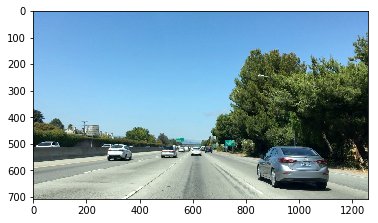

In [3]:
image = mpimg.imread('../img/code/bbox-example-image1.jpg')
plt.imshow(image)

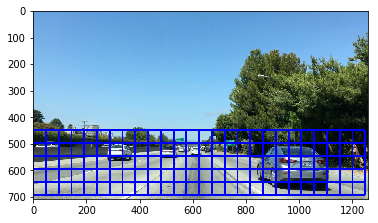

In [4]:
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
draw_image = np.copy(image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


In [15]:
scale =  [1.0, 1.65, 1.97]
out_image=[]
for i in range(len(scale)):
    out_image.append( find_cars(image, y_start_stop[0], y_start_stop[1], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


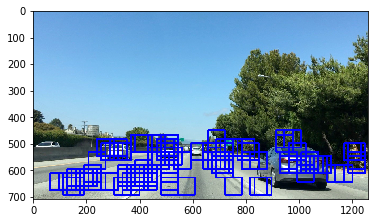

In [14]:
window_img1 = draw_boxes(draw_image, out_image[0], color=(0, 0, 255), thick=6)                    
plt.imshow(window_img1)